# Figure 3F, 6E & S3B

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sympy import symbols, solve, simplify
from scipy.optimize import curve_fit
import sympy as sp
plt.rcParams.update({'font.size': 18})

# Definitions

Function to compute the Hill coefficient of a curve 

In [2]:
def model(x, a, b, c):
    return c*x**a/(x**a+b**a)

def Hill(z,x, params=[1,1,1]):
    y= z-min(z)
    popt, _ = curve_fit(model, x, y, params)
    a,b,c = popt
    fit= c*x**a/(x**a+ b**a)
    
    return [round(a,2), round(b,2), round(c,2)]

In [3]:
def Hill_log(z,x):
    y= np.array(z-min(z))
    y90= max(y)*0.9
    y10= max(y)*0.1

    dif90= np.array([abs(y[kk]-y90) for kk in range(len(y))])
    dif10= np.array([abs(y[kk]-y10) for kk in range(len(y))])

    idx90= dif90.argmin()
    idx10= dif10.argmin()              

    x90= x[idx90]
    x10= x[idx10]

    HillCoeff= round(np.log(81)/np.log(x90/x10),2)
    
    return HillCoeff

Function to define the properties of the axis of a plot

In [4]:
def my_axsis(ax, xlim, ylim, bold=True, scale='lin', ylabel = '', xlabel=''):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_xscale('log', base=10)

# Model 

Definition of the parameters of the model

In [5]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

Evolution equation for T

In [6]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [7]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T)

In [8]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

Evolution equation for the activator Ap

In [9]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+1-Ap)-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=12,Er_v=0.5,KMM3_v=0.05,vMM4_v=1,KMM4_v=0.05):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM3,KMM3_v), (vMM4,vMM4_v), (KMM4,KMM4_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [10]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=12,Er_v=0.5,KMM1_v=0.05,vMM2_v=1,KMM2_v=0.05): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [11]:
expr_Otx = vb+ vo*Ap/((Ka*(1+I/Ki))+Ap)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Import the experimental data

In [12]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

Area of cell surface in contact with FGF (S1)  

In [13]:
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

a65_mean_S1= np.mean(a65_RelContactArea_A)
a66_mean_S1= np.mean(a66_RelContactArea_A)
a68_mean_S1= np.mean(a68_RelContactArea_A)
a67_mean_S1= np.mean(a67_RelContactArea_A)

# Results

In [14]:
Erk_temp = np.logspace(-3,0,200) 

Ap_E= np.array([exprAp(Er_v = Erk_temp[i]) for i in range(len(Erk_temp))])
I_E= np.array([exprI(Er_v = Erk_temp[i]) for i in range(len(Erk_temp))])

Otx_E= np.array(exprOtx(Ap_v=Ap_E,I_v=I_E))
Otx_E_noIn=  np.array(exprOtx(Ap_v=Ap_E,I_v=0.0001*np.ones(len(Erk_temp))))

# Compute Hill coefficients as a function of Erk
n_Ap_log = Hill_log(Ap_E, Erk_temp) 
n_I_log = Hill_log(1-I_E, Erk_temp)

n_Otx_log_E = Hill_log(Otx_E, Erk_temp)
n_Otx_noIn_log_E = Hill_log(Otx_E_noIn, Erk_temp)

# Values of Erk activity computed with the model for each cell type
Erk_a= [0.17868266, 0.00776033, 0.05504878, 0.00204648]

## Figure 3F


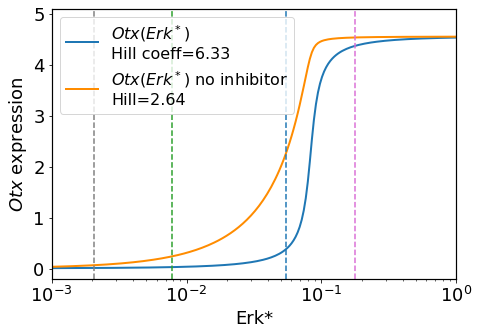

In [15]:
plt.figure(figsize=(7,5))

plt.plot(Erk_temp, Otx_E,label=f'$Otx(Erk^*)$ \nHill coeff={n_Otx_log_E}', color='tab:blue', linewidth=2)
plt.plot(Erk_temp, Otx_E_noIn,label=f'$Otx(Erk^*)$ no inhibitor \nHill={n_Otx_noIn_log_E}', color='darkorange', linewidth=2)
plt.xlabel('Erk*')

plt.axvline(x=Erk_a[0], color='orchid', linestyle='--')
plt.axvline(x=Erk_a[1], color='tab:green', linestyle='--')
plt.axvline(x=Erk_a[2], color='tab:blue', linestyle='--')
plt.axvline(x=Erk_a[3], color='grey', linestyle='--')

my_axsis(ax=plt.gca(), xlim=[0.001,1], ylim=[-0.2,5.1], bold=True, scale='log')
plt.legend(loc=2, ncol=1, fontsize=16)
plt.xlabel('Erk*')
plt.ylabel('$Otx$ expression')
plt.tight_layout()
plt.show()

## Figure S3B

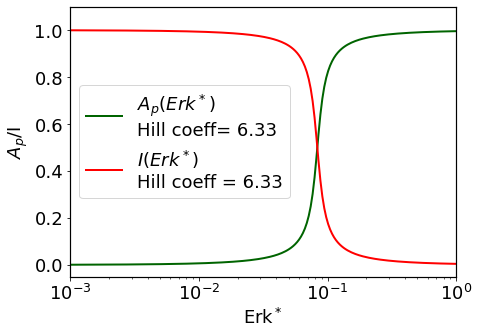

In [17]:
plt.figure(figsize=(7,5))
plt.plot(Erk_temp, Ap_E,'darkgreen',label=f'$A_p(Erk^*)$\nHill coeff= {n_Ap_log}', linewidth=2)
plt.plot(Erk_temp, I_E,'red',label=f'$I(Erk^*)$\nHill coeff = {n_I_log}', linewidth=2) 
my_axsis(ax=plt.gca(), xlim=[0.001,1], ylim=[-0.05,1.1], bold=True, scale='log', xlabel='Erk$^*$', ylabel='$A_p$/I')
plt.legend()
plt.tight_layout()
plt.show()

## Figure 6E

In [18]:
# Compute S1*: 
S1_star = np.array(solve(-1.1265*S1 +0.9092, S1))

# Define S1_temp: (vector from 0 to S1*)
LogS1star = np.log10(S1_star.astype(float))
S1_temp= np.logspace(-2,LogS1star[0],200)

T_temp = [exprT(S1_v=S1_temp[i]) for i in range(len(S1_temp))]
Erk_T = Erk(T_temp)

Ap_E= np.array([exprAp(Er_v = Erk_T[i]) for i in range(len(Erk_T))])
I_E= np.array([exprI(Er_v = Erk_T[i]) for i in range(len(Erk_T))])

Otx_E_S1= np.array(exprOtx(Ap_v=Ap_E,I_v=I_E))
Otx_E_S1_noIn= np.array(exprOtx(Ap_v=Ap_E,I_v=0.0001*np.ones(len(Erk_T))))

# Compute Hill coefficients (log definition)
n_Otx_log = Hill_log(Otx_E_S1, S1_temp) 
n_Otx_noIn_log = Hill_log(Otx_E_S1_noIn, S1_temp)

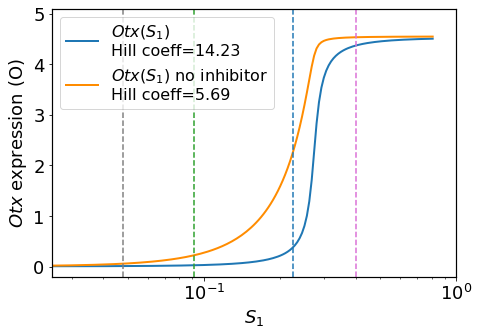

In [19]:
plt.figure(figsize=(7,5))

plt.plot(S1_temp, Otx_E_S1,label=f'$Otx(S_1)$ \nHill coeff={n_Otx_log}', color='tab:blue', linewidth=2)
plt.plot(S1_temp, Otx_E_S1_noIn,label=f'$Otx(S_1)$ no inhibitor \nHill coeff={n_Otx_noIn_log}', color='darkorange', linewidth=2)
plt.xlabel('$S_1$')

plt.axvline(x=a65_mean_S1, color='orchid', linestyle='--')
plt.axvline(x=a66_mean_S1, color='tab:green', linestyle='--')
plt.axvline(x=a67_mean_S1, color='tab:blue', linestyle='--')
plt.axvline(x=a68_mean_S1, color='grey', linestyle='--')

my_axsis(ax=plt.gca(), xlim=[0.025,1], ylim=[-0.2,5.1], bold=True, scale='log')
plt.ylabel('$Otx$ expression (O)')
plt.xlabel('$S_1$')
plt.legend(loc=2, ncol=1, fontsize=16)
plt.tight_layout()
plt.show()